In [ ]:
# Import the required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
import io
import seaborn as sns

%matplotlib inline

In [ ]:
# Set visual style for graphs

plt.style.use('seaborn')

In [ ]:
# Import original dataset and load it into a dataframe

url = "https://media.githubusercontent.com/media/jvrnuno/Hotel_Customer_Segmentation/main/data/raw/H2.csv" # Make sure the url is the raw version of the file on GitHub
download = requests.get(url).content

df = pd.read_csv(io.StringIO(download.decode('utf-8')))


In [ ]:
# Checks number of rows and columsn

df.shape

(79330, 31)

In [ ]:
# First visual inspection of the content

df.head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.0,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,1,Canceled,2015-04-02


In [ ]:
# Checks columns NaN values and data types 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

### 1.2. Feature extraction
In this section, we will create new columns (features) from the existing in the dataset. The objective of this step is to create meaningful attributes that could be better interpreted by the clustering algorithm and by ourselves.

In [ ]:
# Combine "ArrivalDate"columns into a single datetime variable
df['ArrivalDate'] = pd.to_datetime(df[['ArrivalDateYear','ArrivalDateMonth','ArrivalDateDayOfMonth']]
                                   .astype(str).apply(' '.join, 1), format='%Y %B %d')

# Update "ReservationStatusDate" data type
df['ReservationStatusDate'] = df['ReservationStatusDate'].astype('datetime64[ns]')

In [ ]:
# Changes data type to float
df['LeadTime'] = df['LeadTime'].astype('float')

# Creates new variable containing reservation dates by substracting LeadTime from ArrivalDate
df['ReservationDate'] = [df.loc[i,'ArrivalDate'] - timedelta(days=df.loc[i,'LeadTime']) for i in df.index]

In [ ]:
# Print sample of these two variables

df[['ArrivalDate', 'ReservationDate']].head()

,ArrivalDate,ReservationDate
0,2015-07-01,2015-06-25
1,2015-07-01,2015-04-04
2,2015-07-01,2015-04-27
3,2015-07-01,2015-03-31
4,2015-07-02,2015-03-24


In [ ]:
# Creates nwe variable and assing all values to 0
df['ChangedRoom'] = 0

# Assigns 1 to all values where Reserved Room Type is not the same as Assigned Room Type
df['ChangedRoom'].where(df.ReservedRoomType == df.AssignedRoomType, 1, inplace=True)

In [ ]:
# Checks result
df['ChangedRoom'].value_counts()

0    72138
1     7192
Name: ChangedRoom, dtype: int64

In [ ]:
# Creates 'TotalStay'
df['TotalStay'] = (df['StaysInWeekendNights'] + df['StaysInWeekNights']).astype('float')

In [ ]:
# Calculates check out date
df['CheckOutDate'] = [df.loc[i, 'ArrivalDate'] + timedelta(days=df.loc[i,'TotalStay']) for i in df.index]

In [ ]:
# Calculates if guest extended or shorten his/her stay from original booking
for i in df.index:
    if (df.loc[i,'CheckOutDate'] < df.loc[i,'ReservationStatusDate']) & (df.loc[i,'ReservationStatus'] == 'Check-Out'):
        df.loc[i, 'StayChanges'] = 'Extended'
    elif (df.loc[i,'CheckOutDate'] > df.loc[i,'ReservationStatusDate']) & (df.loc[i,'ReservationStatus'] == 'Check-Out'):
        df.loc[i, 'StayChanges'] = 'Early Check-Out'
    else:
        df.loc[i, 'StayChanges'] = 'No Changes'

In [ ]:
# Checks result
df['StayChanges'].value_counts()

No Changes         79324
Early Check-Out        6
Name: StayChanges, dtype: int64

In [ ]:
# Removes blank spaces from string values in df
df = df.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)


## 1.3. Feature analysis and profiling

In this section, we will inspect the values, distribution and descriptive statistics of the variables individually.

In [ ]:
# Check summary statistics for numeric variables

df.describe().T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,0.417270,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,79330.0,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,0.091370,0.372177,0.0,0.0,0.0,0.0,3.0
Babies,79330.0,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0


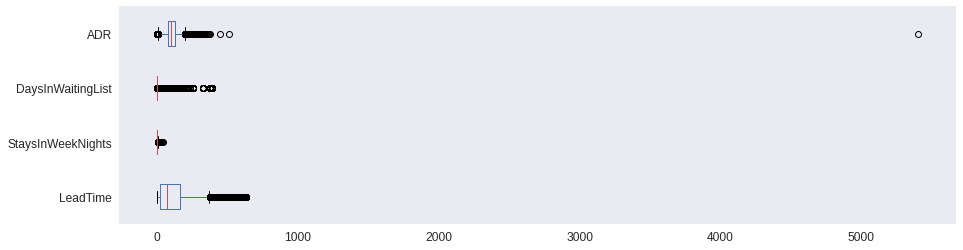

In [ ]:
# Plot boxplot for selected numerical variables

df[['LeadTime', 'StaysInWeekNights', 'DaysInWaitingList', 'ADR']].boxplot(grid=False, vert=False, fontsize=12, figsize=(15,4))
plt.show()

In [ ]:
# Eliminates values in ADR higher than EUR 1,000

df = df[df['ADR'] < 1000]

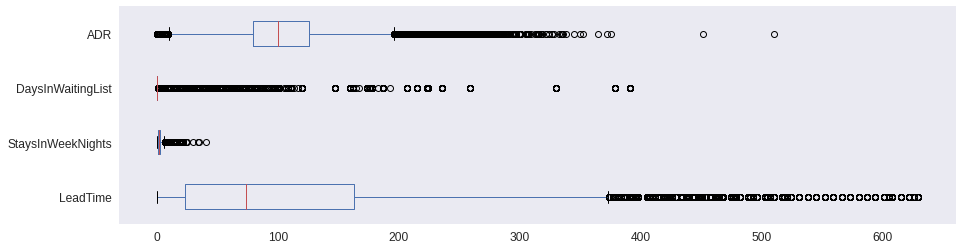

In [ ]:
# Plot boxplot for selected numerical variables

df[['LeadTime', 'StaysInWeekNights', 'DaysInWaitingList', 'ADR']].boxplot(grid=False, vert=False, fontsize=12, figsize=(15,4))
plt.show()

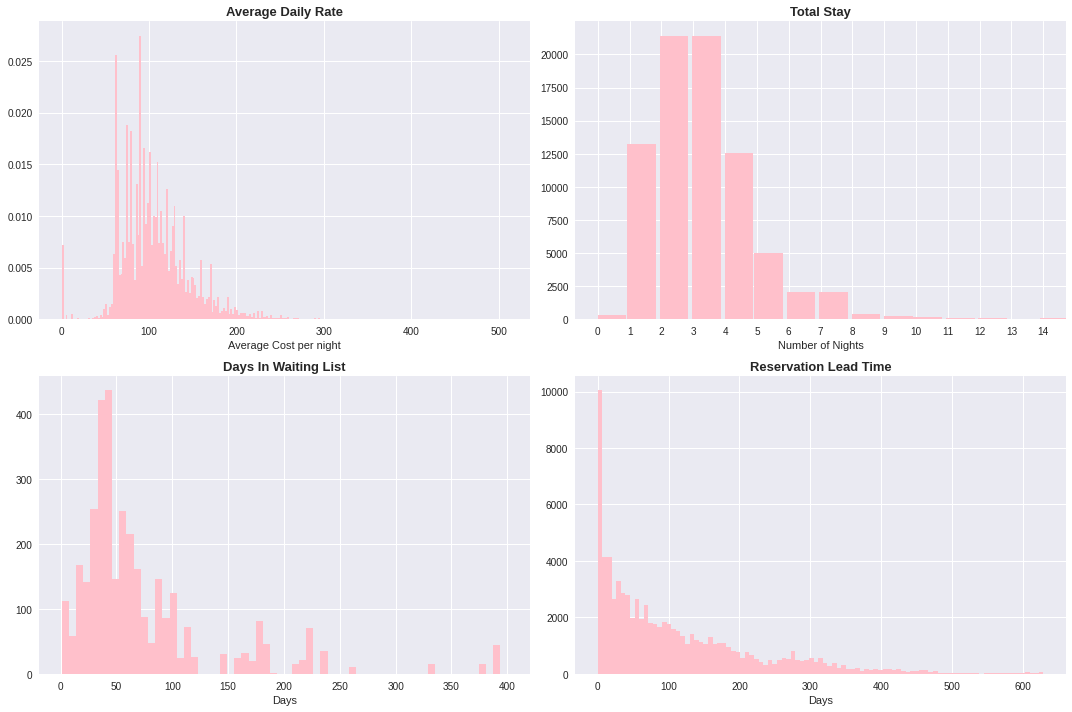

In [ ]:
# Plot histograms for selected variables. We have adjusted the ranges and bin number for visualization purposes

colors = ["#ffc0cb"]
customPalette = sns.set_palette(sns.color_palette(colors))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10), dpi=72)

ax0.hist(df['ADR'], bins='auto', density=True)
ax0.set_title('Average Daily Rate', fontsize=13, fontweight='bold')
ax0.set_xlabel('Average Cost per night')

ax1.hist(df['TotalStay'], bins='auto', range=(0,14), width=0.9)
ax1.set_xticks(range(0,15))
ax1.set_title('Total Stay', fontsize=13, fontweight='bold')
ax1.set_xlabel('Number of Nights')

ax2.hist(df['DaysInWaitingList'], bins='auto', range=(1,400))
ax2.set_title('Days In Waiting List', fontsize=13, fontweight='bold')
ax2.set_xlabel('Days')

ax3.hist(df['LeadTime'], bins='auto')
ax3.set_title('Reservation Lead Time', fontsize=13, fontweight='bold')
ax3.set_xlabel('Days')

plt.tight_layout()
plt.show()

In [ ]:
# Create a function to generate a PMF plot for categorical and discrete variables

def Pmf(series, Title):
    '''Generates a probability mass function (PMF) of a pandas series'''
    value = series.value_counts().sort_index()
    pmf = value*100 / len(series)
    plt.bar(value.index, pmf)
    plt.xticks(value.index, fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.title(Title, fontsize=15, fontweight='bold')

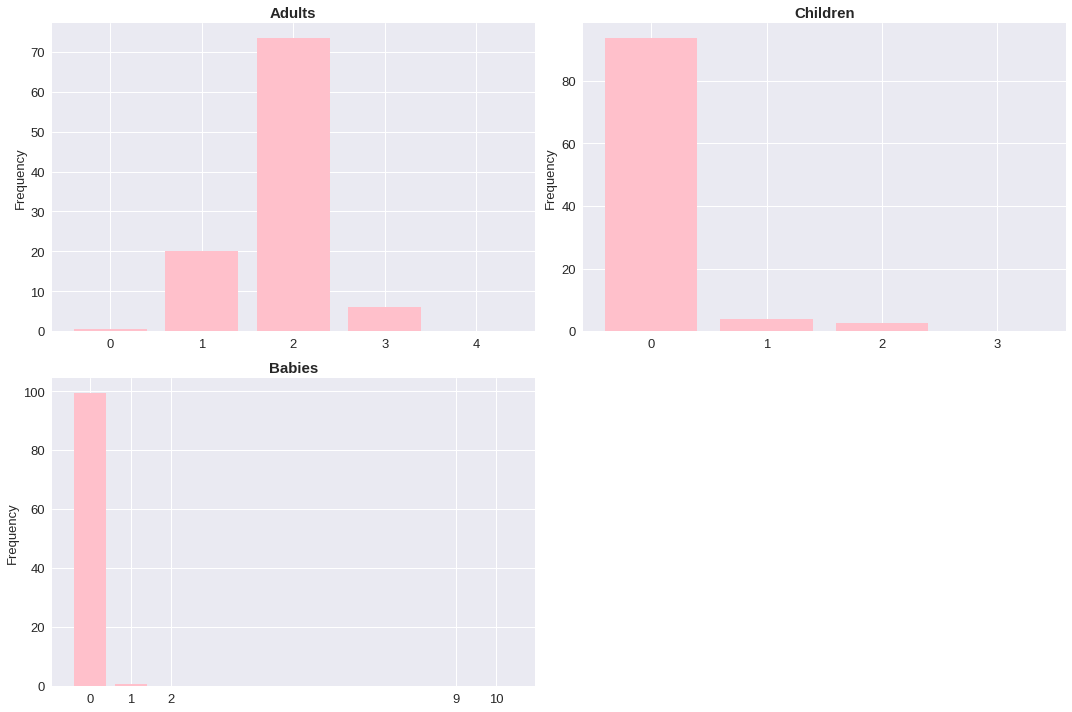

In [ ]:
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot number of adults per booking
plt.subplot(2,2,1)
Pmf(df['Adults'], 'Adults')

# Plot number of children per booking
plt.subplot(2,2,2)
Pmf(df['Children'], 'Children')

# Plot number of babies per booking
plt.subplot(2,2,3)
Pmf(df['Babies'], 'Babies')

plt.tight_layout()
plt.show()

In [ ]:
# Print reservations with 0 'adults' 

df[df['Adults'] == 0].head()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,ArrivalDate,ReservationDate,ChangedRoom,TotalStay,CheckOutDate,StayChanges
332,0,132.0,2015,July,30,23,2,5,0,0.0,0,HB,PRT,Groups,TA/TO,0,0,0,A,A,4,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-30,2015-07-23,2015-03-13,0,7.0,2015-07-30,No Changes
862,0,0.0,2015,August,33,9,2,0,0,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,F,B,0,No Deposit,9,NULL,0,Contract,0.0,0,0,Check-Out,2015-08-11,2015-08-09,2015-08-09,1,2.0,2015-08-11,No Changes
924,0,1.0,2015,August,33,10,1,1,0,3.0,0,BB,PRT,Direct,Direct,0,0,0,B,B,1,No Deposit,NULL,NULL,0,Transient-Party,9.0,0,0,Check-Out,2015-08-12,2015-08-10,2015-08-09,0,2.0,2015-08-12,No Changes
960,0,0.0,2015,August,33,10,9,20,0,0.0,0,SC,PRT,Online TA,Direct,0,0,0,E,K,20,No Deposit,NULL,47,0,Transient,0.0,0,0,Check-Out,2015-09-08,2015-08-10,2015-08-10,1,29.0,2015-09-08,No Changes
988,0,104.0,2015,August,33,11,0,3,0,2.0,0,BB,FRA,Online TA,TA/TO,0,0,0,B,B,1,No Deposit,7,NULL,0,Transient-Party,6.0,0,2,Check-Out,2015-08-14,2015-08-11,2015-04-29,0,3.0,2015-08-14,No Changes


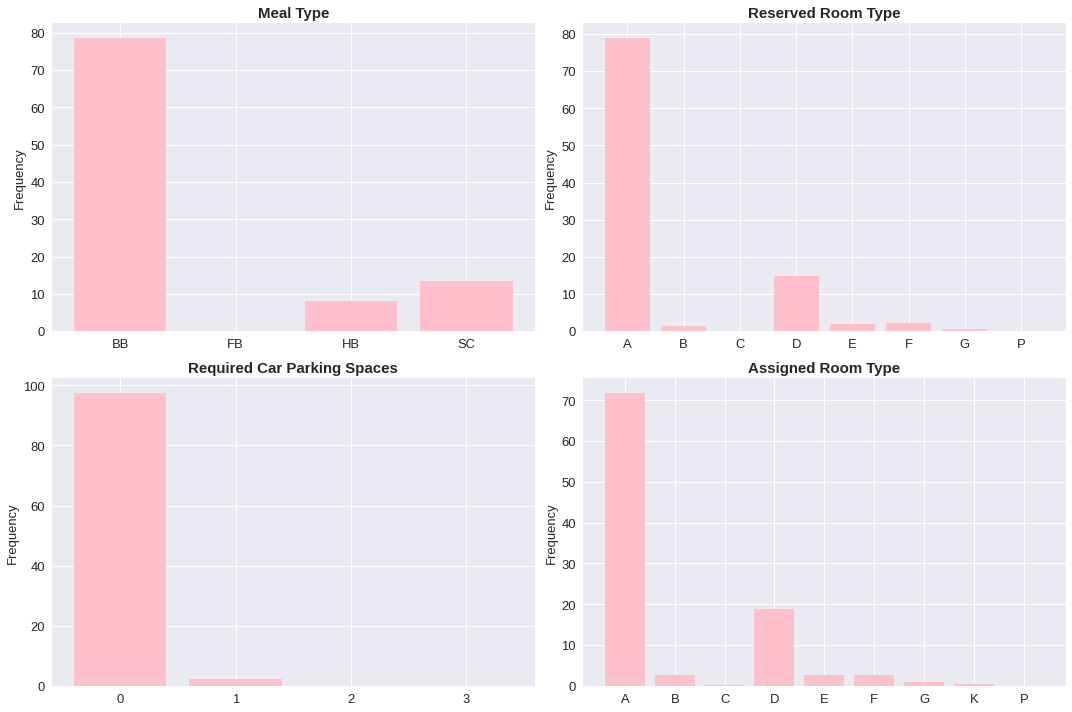

In [ ]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot type of meal per booking
plt.subplot(2,2,1)
Pmf(df['Meal'], 'Meal Type')

# Plot Reserved Room Type per booking
plt.subplot(2,2,2)
Pmf(df['ReservedRoomType'], 'Reserved Room Type')

# Plot Required Car Parking Spaces per booking
plt.subplot(2,2,3)
Pmf(df['RequiredCarParkingSpaces'], 'Required Car Parking Spaces')

# Plot Assigned Room Type per booking
plt.subplot(2,2,4)
Pmf(df['AssignedRoomType'], 'Assigned Room Type')

plt.tight_layout()
plt.show()

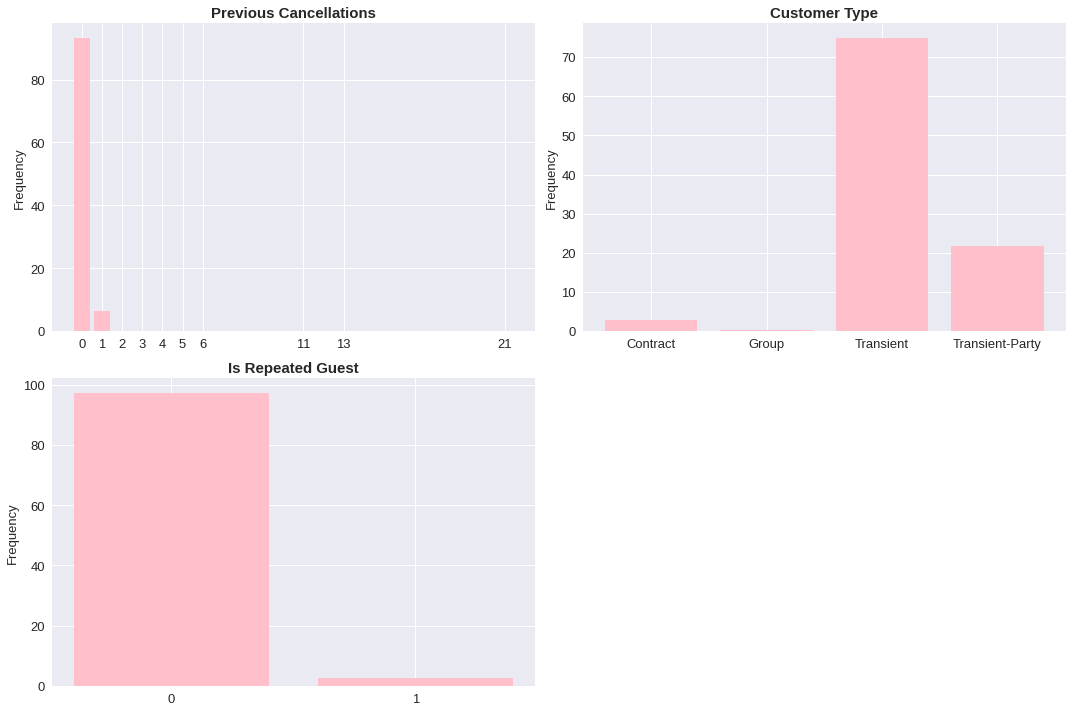

In [ ]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot customer previous cancellations
plt.subplot(2,2,1)
Pmf(df['PreviousCancellations'], 'Previous Cancellations')

# Plot Customer Type
plt.subplot(2,2,2)
Pmf(df['CustomerType'], 'Customer Type')

# Plot Is Repeated Guest
plt.subplot(2,2,3) 
Pmf(df['IsRepeatedGuest'], 'Is Repeated Guest')



plt.tight_layout()
plt.show()

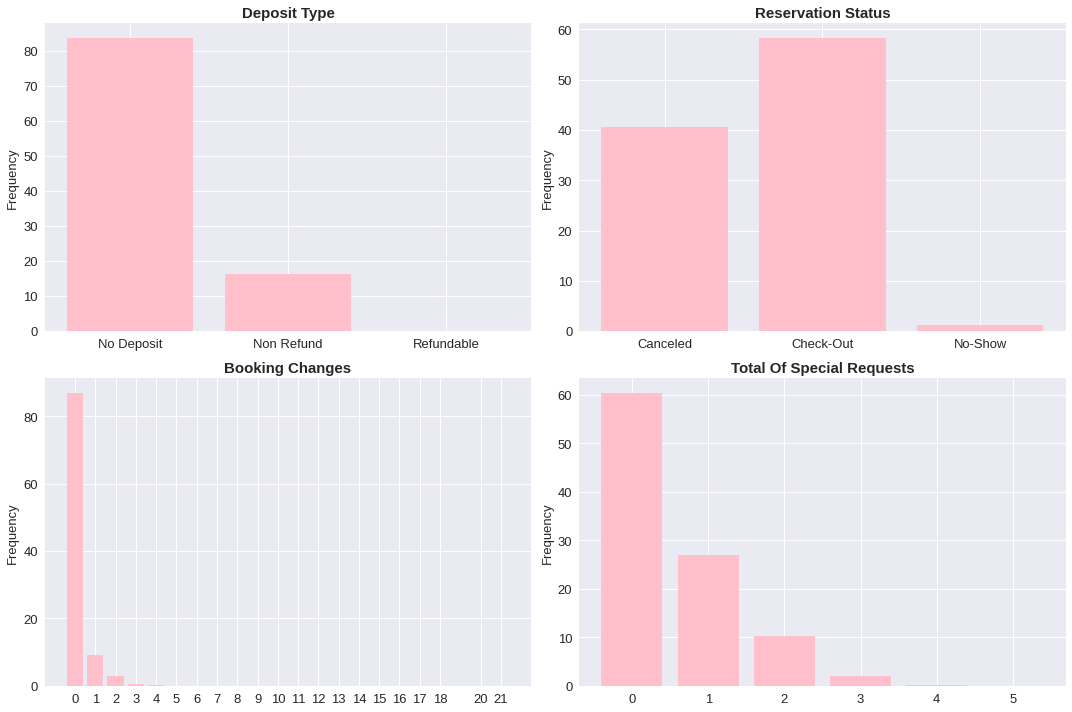

In [ ]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot Deposit Type per booking
plt.subplot(2,2,1)
Pmf(df['DepositType'], 'Deposit Type')

# Plot Canceled bookings
plt.subplot(2,2,2)
Pmf(df['ReservationStatus'], 'Reservation Status')

# Plot Booking Changes
plt.subplot(2,2,3) 
Pmf(df['BookingChanges'], 'Booking Changes')

# Plot Total Of Special Requests per booking
plt.subplot(2,2,4)
Pmf(df['TotalOfSpecialRequests'], 'Total Of Special Requests')

plt.tight_layout()
plt.show()

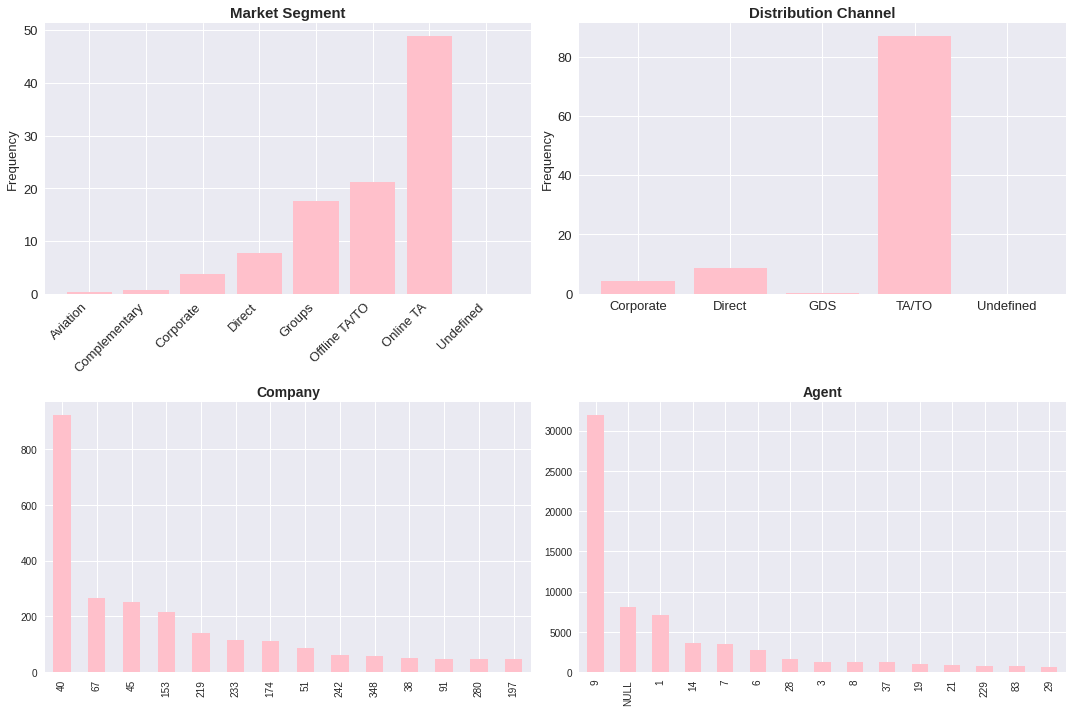

In [ ]:
# Creates figure for plots
fig = plt.figure(figsize=(15,10), dpi=72)

# Plot Market Segment per booking
plt.subplot(2,2,1)
Pmf(df['MarketSegment'], 'Market Segment')
plt.xticks(rotation=45, horizontalalignment='right')

# Plot Distribution Channel per booking
plt.subplot(2,2,2)
Pmf(df['DistributionChannel'], 'Distribution Channel')

# Plot Company making the reservation
plt.subplot(2,2,3) 
df['Company'].value_counts()[1:15].plot(kind='bar')
plt.title('Company', fontsize=14, fontweight='bold')

# Plot Agent related with the reservation
plt.subplot(2,2,4)
df['Agent'].value_counts()[:15].plot(kind='bar')
plt.title('Agent', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Shows the number of countries origin of guests

print('There are '+str(df['Country'].nunique())+' different countries of origin in the dataset')

There are 166 different countries of origin in the dataset


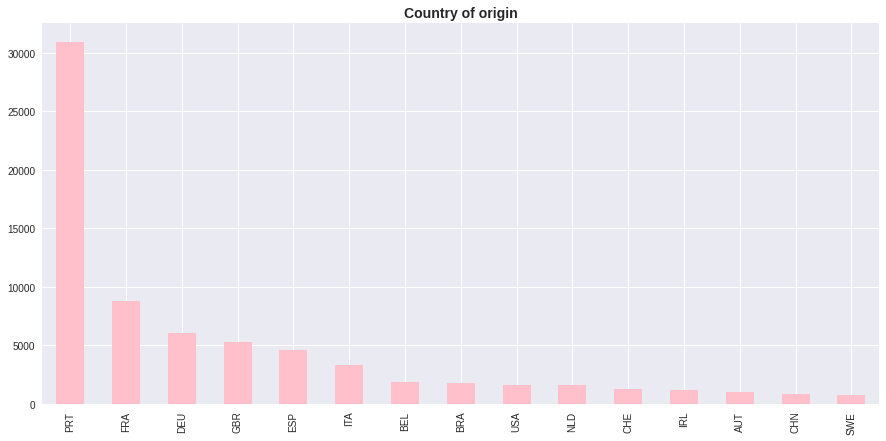

In [ ]:
# Creates figure for plots
fig = plt.figure(figsize=(15,7), dpi=72)

# Plots the first more common country of origin of customers
df['Country'].value_counts()[:15].plot(kind='bar')
plt.title('Country of origin', fontsize=14, fontweight='bold')
plt.show()

In [ ]:
# Creates filter to remove codes with no country associated
cond = (df['Country'] != 'TMP') & (df['Country'] != 'ATA') & (df['Country'] != 'CN')

# Removes observations with misspelled country codes
df = df[cond]

In [ ]:
# Creates a Series containing total number of arrivals per month of the year

df_arrivals = df['ArrivalDateMonth'].groupby(df['ArrivalDateMonth']).count()
df_arrivals.index = pd.to_datetime(df_arrivals.index, format='%B')
df_arrivals.sort_index(inplace=True)
df_arrivals.index = df_arrivals.index.strftime('%b')

In [ ]:
# Creates a Series containing total number of bookings per month of the year

df['ReservationMonth'] = [i.month for i in df['ReservationDate']]

df_bookings = df['ReservationMonth'].groupby(df['ReservationMonth']).count()
df_bookings.index = pd.to_datetime(df_bookings.index, format='%m')
df_bookings.sort_index(inplace=True)
df_bookings.index = df_bookings.index.strftime('%b')

In [ ]:
# Converts month number to string
to_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 
           7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
df['ReservationMonth'] = df['ReservationMonth'].map(to_name)

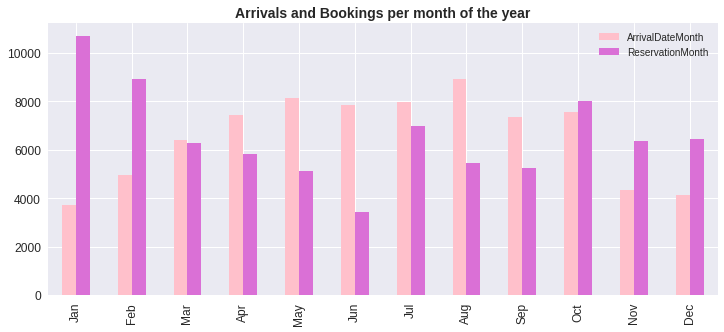

In [ ]:
# Create figure and axis
# Create an array with the colors you want to use
colors = ["#ffc0cb", "#DA70D6"]
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))
fig, ax = plt.subplots(figsize=(12,5), dpi=72)

# Creates plot showing reservations and arrivals per month of year
pd.concat([df_arrivals, df_bookings], axis=1).plot(kind='bar', ax=ax)
ax.set_title('Arrivals and Bookings per month of the year', fontsize=14, fontweight='bold')
ax.tick_params(labelsize=12)

plt.show()

In [ ]:
# Replace Undefined data points in MarketSegment
df['MarketSegment'].replace('Undefined', np.NaN, inplace=True)

# Replace Undefined data points in DistributionChannel
df['DistributionChannel'].replace('Undefined', np.NaN, inplace=True)

# Remove trailing spaces from values in DepositType
df['DepositType'] = df['DepositType'].map(lambda x: x.strip())
# Replace Undefined data points in DistributionChannel
df['DepositType'].replace('Refundable', np.NaN, inplace=True)

In [ ]:
# Select reservations with values of Adults, Children and Babies equal to 0.
cond = (df.Adults == 0) & (df.Children == 0) & (df.Babies == 0)

# Replace those values for NaN
df['Adults'].mask(cond, inplace=True)

In [ ]:
# Replace 9 and 10 values in Babies
df['Babies'].replace([9,10], np.NaN, inplace=True)

In [ ]:
# Checks for NaN values in df

df.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                         167
Children                         4
Babies                           2
Meal                             0
Country                         24
MarketSegment                    2
DistributionChannel              4
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                     19
Agent                            0
Company                          0
DaysInWaitingList                0
CustomerType                     0
ADR                              0
RequiredCarParkingSpaces         0
TotalOfSpecialReques

In [ ]:
# Calculates percentage of NaN values in ADR
per = df.Adults.isna().sum()*100 / df.Adults.shape[0]
print('The proportion of NaN values in ADR feature is '+str(round(per, 3))+'%')

The proportion of NaN values in ADR feature is 0.212%


In [ ]:
# Removes rows with NaN values

df.dropna(axis=0, inplace=True)

In [ ]:
from google.colab import files
df.to_csv('clean.csv') 
files.download('clean.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>